# Sentencias Estructurales

In [1]:
%%capture --no-display
%load_ext autoreload
%autoreload 2
from reporte import *
from IPython.display import Latex

import sys
sys.path.insert(0, '../../')
from nlppen.descripcion import *

# Inicialización y Carga de datos
spark, sc = init_spark()
estructurales = cargar_datos(spark)

21/10/19 16:38:25 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [52]:
from datetime import date
(estructurales.seleccion.sdf
                                .where('anno < 2019')
                                .withColumn('dias_tramite', F.datediff('fechahora_ext', 'FechaSolicitud'))
                                .withColumn('plazosDefinidos', F.datediff('plazosDefinidos', '1970-01-01'))
                                )

AnalysisException: cannot resolve '`1970-01-01`' given input columns: [Cantón_ents, CitaSentencias_ents, Constitución_ents, EntidadPublica_ents, FechaSolicitud, Fecha_ents, Fechahora_ents, Ley_ents, Magistrado_ents, Recurrente_ents, Recurrido_ents, Redactor_ents, Reglamento_ents, _id, anno, archivo, cleanText, dias_tramite, expediente, extension_por_lo_tanto, extension_sentencia, fechahora_ext, num, plan, plazo, plazosDefinidos, redactor_ext, se_ordena, se_ordena_Ent_Pub, se_ordena_GPE, se_ordena_LOC, se_ordena_MISC, se_ordena_ORG, se_ordena_PER, seguimiento, tema, tema_prob, termino_ext, termino_lst, tipoResolucion_ext, txt, voto_salvado];
'Project [archivo#54, txt#55, cleanText#56, num#57L, fechahora_ext#58, redactor_ext#59, tipoResolucion_ext#60, termino_ext#61, voto_salvado#62, tema#63, Recurrente_ents#64, Cantón_ents#65, Fecha_ents#66, Constitución_ents#67, Redactor_ents#68, Ley_ents#69, EntidadPublica_ents#70, tema_prob#71, termino_lst#72, expediente#73, Fechahora_ents#74, CitaSentencias_ents#75, Recurrido_ents#76, Reglamento_ents#77, ... 18 more fields]
+- Project [archivo#54, txt#55, cleanText#56, num#57L, fechahora_ext#58, redactor_ext#59, tipoResolucion_ext#60, termino_ext#61, voto_salvado#62, tema#63, Recurrente_ents#64, Cantón_ents#65, Fecha_ents#66, Constitución_ents#67, Redactor_ents#68, Ley_ents#69, EntidadPublica_ents#70, tema_prob#71, termino_lst#72, expediente#73, Fechahora_ents#74, CitaSentencias_ents#75, Recurrido_ents#76, Reglamento_ents#77, ... 18 more fields]
   +- Filter (anno#94 < 2019)
      +- Filter (anno#94 < 2019)
         +- Relation[archivo#54,txt#55,cleanText#56,num#57L,fechahora_ext#58,redactor_ext#59,tipoResolucion_ext#60,termino_ext#61,voto_salvado#62,tema#63,Recurrente_ents#64,Cantón_ents#65,Fecha_ents#66,Constitución_ents#67,Redactor_ents#68,Ley_ents#69,EntidadPublica_ents#70,tema_prob#71,termino_lst#72,expediente#73,Fechahora_ents#74,CitaSentencias_ents#75,Recurrido_ents#76,Reglamento_ents#77,... 17 more fields] parquet


In [2]:
estructurales.seleccion.sdf = (estructurales.seleccion.sdf
                                .where('anno < 2019')
                                .withColumn('dias_tramite', F.datediff('fechahora_ext', 'FechaSolicitud'))
                                .withColumn('plazosDefinidos', F.datediff('plazosDefinidos', '1970-01-01'))
                                )

columnas = ['archivo',
            'expediente',
            'anno',
            'fechahora_ext',
            'redactor_ext',
            'tipoResolucion_ext',
            'termino_ext',
            'voto_salvado',
            'tema',
            'tema_prob',
            'Recurrente_ents',
            'Cantón_ents',
            'Fecha_ents',
            'Constitución_ents',
            'Redactor_ents',
            'Ley_ents',
            'EntidadPublica_ents',
            'Fechahora_ents',
            'CitaSentencias_ents',
            'Recurrido_ents',
            'Reglamento_ents',
            'Magistrado_ents',
            'seguimiento',
            'se_ordena',
            'plan',
            'plazo',
            'se_ordena_PER',
            'se_ordena_LOC',
            'se_ordena_ORG',
            'se_ordena_MISC',
            'se_ordena_GPE',
            'se_ordena_Ent_Pub',
            'extension_sentencia',
            'extension_por_lo_tanto',
            'plazosDefinidos',
            'FechaSolicitud']

descr = Descripcion(estructurales.seleccion, './extraccion')
descr.guardar_lista(columnas, sheet='Lista de Sentencias con lugar')

/opt/conda/lib/python3.9/site-packages/pyspark/sql/pandas/conversion.py:87: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unsupported type in conversion to Arrow: ArrayType(TimestampType,true)
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warnings.warn(msg)


## Introducción

En este reporte se exploran resultados preliminares de la aplicación de los criterios de clasificación de sentencias estructurales en el corpus de resoluciones de la Sala Constitucional de Costa Rica. Estos criterios están definidos en el documento de trabajo _"Propuesta de definición y operacionalización de sentencias estructurales"_ (Estado de la Justicia, 2021), donde se agrupan las tres dimensiones Contenido, Forma y Calidad:

### Dimensión Contenido
 
 
| Num. | Característica                                                                | Operacionalización               | Unidad de registro                               |
| ---- |:------------------------------------------------------------------------------|:----------------------------------|:--------------------------------------------------|
| CO01  | Busca solucionar un problema estructural, reiterado y serio                   | Problema estructural que atiende | Listado de problemas estructurales a identificar |
| CO02  | Se centra en la protección de temáticas relacionados con los derechos humanos | 1. Se menciona un derecho humano afectado? <br> 2. Cuál? | 1. Sí y no.  <br> 2. Listado de derechos humanos a identificar |
| CO03  | Afecta a un grupo de personas, más allá de quién (es) presentaron el recurso | 1. En la sección general hay más de un demandante (un nombre). <br> 2. Por lo tanto menciona un grupo de la población específico | 1. Sí o no.  | Contien la palabra indígenas, personas con discapacidad, privados de libertad, vecinos, estudiantes, pacientes, etc. |
| CO04  | Sirve como referente en la resolución de un elevado número de casos similares o idénticos |  1. Es citado en otras resoluciones. <br> 2. ¿Cuáles? | 1.Número de veces que se cita en otras resoluciones. <br> 2.Expedientes en los cuales se cita. |
| ~~CO05~~  | Establece como una condición dar seguimiento para verificar el cumplimiento efectivo de dicha sentencia | Contiene la palabra "Seguimiento" | 1. Sí o no. <br> 2. (Informes??, planificación??) |
 
 

### Dimensión Forma

| Num. | Característica  | Operacionalización | Unidad de registro   |
| ---- |:----------------|--------------------|----------------------|
| FO01 | Implica órdenes/disposiciones de cumplimiento obligatorio  | Contiene un "Se ordena" <br> (?? Con un plazo)  | Sí o no.   |
| FO02 | Señala qué debe hacerse y a quién (persona o ente) le corresponde realizar dicha acción  | Después de la palabra “se ordena” se menciona un nombre de la persona o institución  | Extraer el nombre completo.   |
| FO03 | Define plazos para el cumplimiento de las órdenes/disposiciones emitidas  | En el Por Tanto se menciona la palabra “meses”  | Extraer las palabras o números antes de meses.   |
| FO04 | Se registran declaraciones/pronunciamientos repetidos por parte de la Sala Constitucional  | Cantidad de referencia a otras sentencias similares o iguales  | Número de referencias <br> Número de expediente de las sentencias a las cuales se hace referencia  |
| FO05 | Señala que para el cumplimiento del problema estructural se debe elaborar un plan  | Aparece la palabra “plan”  | Sí o no  |
| FO06 | Hay más de una institución involucrada en la ejecución y supervisión del cumplimiento de la sentencias  | ¿Cuántas instituciones están involucradas en la ejecución y supervisión del cumplimiento de la sentencias?  | Sí o no <br> Número de instituciones  |

### Dimensión Calidad
| Característica   | Operacionalización | Unidad de registro   |
|:-----------------|--------------------|----------------------|
| Extensión de la sentencia  | Cantidad de palabras (entre X y Y)  | Números absolutos  |
| Tiempo que tomó emitir la resolución  | Meses que tomó emitir la resolución (entre X y Y)  | Fecha de presentación del recurso y fecha del voto  |
| Uso de lenguaje jurídico y técnico  | Cantidad de términos jurídicos y técnicos únicos citados  | Términos únicos en el texto.  |
| Profundidad de las argumentaciones expuestas  |    |   |
| Cantidad de fuentes/autores citados  | En el Considerando: se mencionan autores, líneas filosóficas o literatura   | Incluye las palabras doctrina, literatura,  |
| Jurisprudencia citada  | En el Considerando se citan instrumentos internacionales referidos, u organismos internacionales, incluyendo cortes internacionales, otros tribunales constitucionales  | Cantidad de instrumentos. <br> <br>Listado de instrumentos citados. <br> <br>Listado de organizaciones citadas  |
| Redactada por los magistrados y magistradas propietarios  | Redacta un propietario. <br> <br> <br>Votación la realizan  magistrados (as) propietarios (as)   | Si o no.  <br> <br>Cantidad de magistrados (as) propietarios (as) que votan  |

# Dimensión Contenido

## Criterio CO5. Seguimiento

In [3]:
seguimiento_total = estructurales.seleccion.sdf.where('seguimiento != 0').count()

Latex(f'''
El objetivo es identificar si en el portanto de la sentencia se hace referencia
a alguna estrategia de seguimiento, ya sea por la misma Sala o por un tercero.


Para obtener la información, se realiza una búsqueda de la palabra seguimiento
en el portanto pero no se obtienen resultados concluyentes: solo se obtienen
{seguimiento_total} sentencias con la palabra, pero la mayor parte no hacen
referencia a un plan de seguimiento en particular.

''')

<IPython.core.display.Latex object>

# Dimensión Forma

## FO01. Se ordena

In [4]:
se_ordena_total = (estructurales
                    .seleccion.sdf
                    .where('se_ordena != 0')
                    .count())


con_lugar_total = (estructurales
                     .seleccion.sdf
                     .where('termino_ext == "Con lugar" OR  termino_ext == "Con lugar parcial" ')
                     .count())

porcentaje_seordena = 100*se_ordena_total/con_lugar_total

In [5]:
porcentaje_seordena

62.965837683809845

En las sentencias "con lugar", normalmente se le ordena a los recurridos alguna acción relacionada a la naturaleza de la sentencia. Esta orden se da a personas particulares, en puestos públicos o pertenecientes a alguna institución o entidad. 

In [6]:
Latex(f'''
Del total de sentencias _"con lugar"_ o _"con lugar parcial"_, el {porcentaje_seordena:1.2f}%, manteniendo un comportamiento homgéneo durante todos los años (Figura 1).
''')

<IPython.core.display.Latex object>

<AxesSubplot:title={'center':"Sentencias 'Con lugar' con los términos 'Se ordena'"}, xlabel='Año', ylabel='Cantidad'>

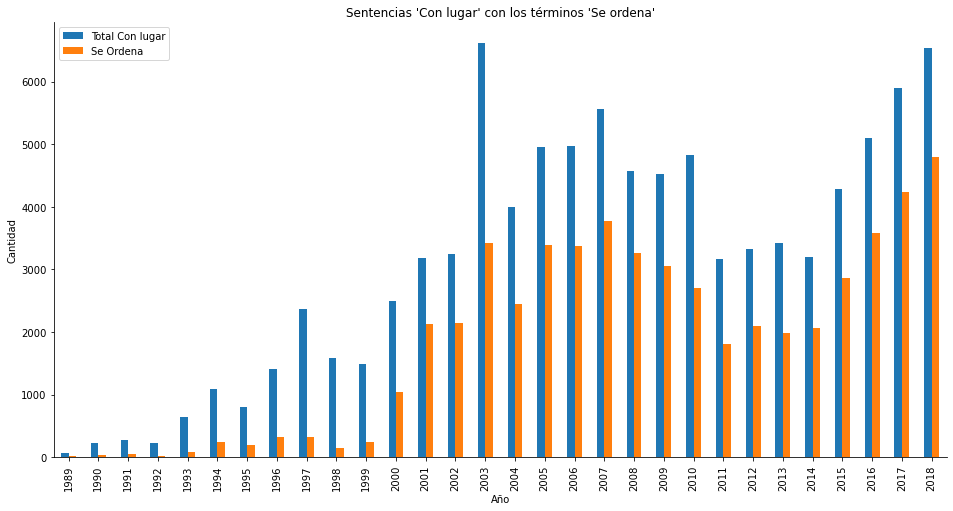

In [7]:
grafico_se_ordena_anno(estructurales)

## FO02. Se señala qué debe hacerse y a quién

Instituciones que aparecen en se ordena

In [8]:
from pyspark.sql import functions as F

df_se_ordena_LOC = (estructurales.seleccion.sdf
 .where(estructurales.seleccion.sdf.se_ordena_LOC.isNotNull())
 .select(F.explode('se_ordena_LOC').alias('se_ordena_LOC'), 'anno')
 .groupby('se_ordena_LOC')
 .count()
 .sort(F.desc('count'))
).toPandas()
descr.guardar_df(df_se_ordena_LOC, sheet='Se Ordena LOC (Sin limpiar)')
df_se_ordena_LOC[:100]


,se_ordena_LOC,count
0,Ministerio de Educación Pública,7159
1,Sala,2461
2,Ministerio Público,2098
3,Hospital Dr. Rafael Ángel Calderón Guardia,1532
4,Zona de Menor Desarrollo,1367
...,...,...
95,Farmacoepidemiología,43
96,Directora del Área,42
97,Alcalde Municipal de Puntarenas,42
98,Guanacaste,42


Plazo en el cumplimiento de la orden

In [9]:
df_se_ordena_Ent_Pub = (estructurales.seleccion.sdf
 .where(estructurales.seleccion.sdf.se_ordena_Ent_Pub.isNotNull())
 .select(F.explode('se_ordena_Ent_Pub').alias('se_ordena_Ent_Pub'), 'anno')
 .groupby('se_ordena_Ent_Pub')
 .count()
 .sort(F.desc('count'))
).toPandas()

descr.guardar_df(df_se_ordena_Ent_Pub, sheet='Se Ordena Entidades Públicas')
df_se_ordena_Ent_Pub[:10]


,se_ordena_Ent_Pub,count
0,Ministerio de Educacion Publica,9577
1,Caja Costarricense de Seguro Social,3863
2,Direccion General Del Servicio Civil,1222
3,Ministerio de Salud,512
4,Instituto de Desarrollo Agrario,361
5,Instituto Nacional de Seguros,358
6,Fondo Nacional de Becas,253
7,Ministerio de Seguridad Publica,230
8,Instituto Costarricense de Electricidad,216
9,Instituto Mixto de Ayuda Social,205


<AxesSubplot:ylabel='Frequency'>

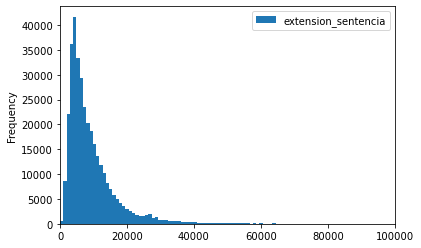

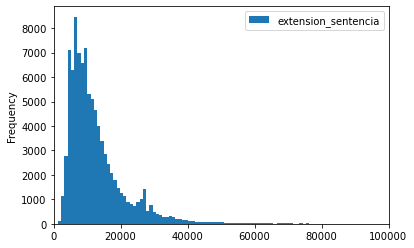

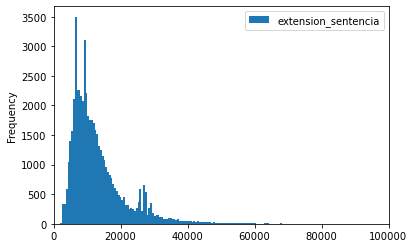

In [10]:
import numpy as np

(estructurales.seleccion.sdf.select('extension_sentencia')
).toPandas().plot.hist(bins=1000, xlim=(0,100000))

(estructurales
 .seleccion.sdf
 .where('termino_ext == "Con lugar" OR  termino_ext == "Con lugar parcial" ')
 .select('extension_sentencia')
).toPandas().plot.hist(bins=1000, xlim=(0,100000))

(estructurales
 .seleccion.sdf
 .where('termino_ext == "Con lugar" OR  termino_ext == "Con lugar parcial" ')
 .where('se_ordena == 1')
 .select('extension_sentencia')
).toPandas().plot.hist(bins=1000, xlim=(0,100000))

<AxesSubplot:ylabel='Frequency'>

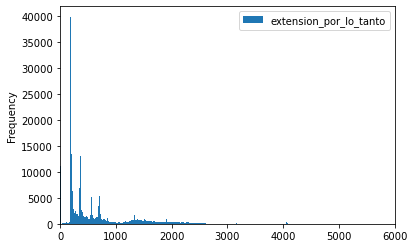

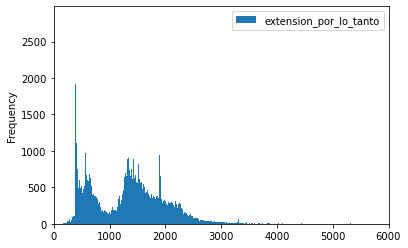

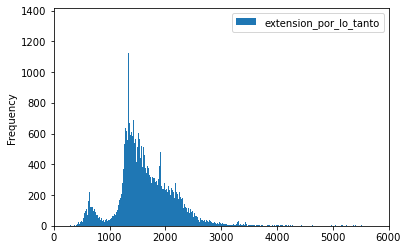

In [11]:
import numpy as np

(estructurales
 .seleccion.sdf
 .select('extension_por_lo_tanto')
 .where('extension_por_lo_tanto < 10000')
).toPandas().plot.hist(bins=1000, xlim=(0,6000))

(estructurales
 .seleccion.sdf
 .where('termino_ext == "Con lugar" OR  termino_ext == "Con lugar parcial" ')
 .select('extension_por_lo_tanto')
 .where('extension_por_lo_tanto < 10000')
).toPandas().plot.hist(bins=1000, xlim=(0,6000))

(estructurales
 .seleccion.sdf
 .where('termino_ext == "Con lugar" OR  termino_ext == "Con lugar parcial" ')
 .where('se_ordena == 1')
 .where('extension_por_lo_tanto < 10000')
 .select('extension_por_lo_tanto')
).toPandas().plot.hist(bins=1000, xlim=(0,6000))

In [12]:
from pyspark.sql.functions import explode, desc
from pyspark.sql import functions as F
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)



In [13]:
cant_con_plazo = (estructurales
 .seleccion.sdf             
 .where('plazosDefinidos is not Null')
 .where('se_ordena == 1')
 .where('termino_ext == "Con lugar" OR  termino_ext == "Con lugar parcial" ')
).toPandas()

cant_con_lugar = (estructurales
 .seleccion.sdf             
 .where('se_ordena == 1')
 .where('termino_ext == "Con lugar" OR  termino_ext == "Con lugar parcial" ')
).count()


cant_con_plazo.shape[0]/cant_con_lugar


/opt/conda/lib/python3.9/site-packages/pyspark/sql/pandas/conversion.py:87: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unsupported type in conversion to Arrow: ArrayType(TimestampType,true)
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warnings.warn(msg)


0.3022728519446324

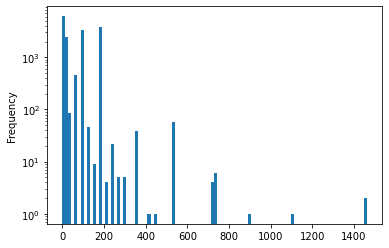

In [14]:
#cant_con_plazo.plazosDefinidos  - 
timedeltas_plazo = (cant_con_plazo.plazosDefinidos.apply(lambda x: x[0]) -  pd.to_datetime('1970-01-01')).dt.days
timedeltas_plazo.plot.hist(bins=100)
plt.yscale('log')

cant_con_plazo['plazo_en_dias'] = timedeltas_plazo
descr.guardar_df(cant_con_plazo[columnas], sheet='Plazo "Con Lugar"')

In [22]:
# FechaSolicitud

cant_con_plazo = (estructurales
 .seleccion.sdf             
 .where('FechaSolicitud is not Null')
 .where('termino_ext == "Con lugar" OR  termino_ext == "Con lugar parcial" ')
).toPandas()

cant_con_lugar = (estructurales
 .seleccion.sdf             
 .where('termino_ext == "Con lugar" OR  termino_ext == "Con lugar parcial" ')
).count()


print(cant_con_plazo.shape[0])
print(cant_con_lugar)

/opt/conda/lib/python3.9/site-packages/pyspark/sql/pandas/conversion.py:87: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unsupported type in conversion to Arrow: ArrayType(TimestampType,true)
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warnings.warn(msg)


77963
94051


<AxesSubplot:ylabel='Frequency'>

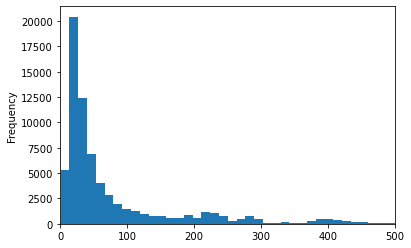

In [51]:
# cant_con_plazo.FechaSolicitud
cant_con_plazo.fechahora_ext[:10]

t_tramite = (estructurales
 .seleccion.sdf             
 .where('termino_ext == "Con lugar" OR  termino_ext == "Con lugar parcial" ')
 .withColumn('dias_tramite', F.datediff('fechahora_ext', 'FechaSolicitud'))
).toPandas()

# t_tramite.dias_tramite.plot.hist(bins=100)


t_tramite.dias_tramite.plot.hist(bins=10000, xlim=(0,500))


In [16]:
descr.export.guardar('estructurales_crudo[18-10-21].xlsx')